In [6]:
import json
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset

In [7]:
class BasketballCocoDataset(Dataset):
    def __init__(self, root_dir, split="train", categories_to_use=None):
        """
        Args:
            root_dir: Path to basketball-player-detection-3.v1i.coco directory
            split: One of "train", "valid", or "test"
            categories_to_use: List of category names to filter by (e.g., ["ball", "player"])
                              If None, uses all categories
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.split_dir = self.root_dir / split
        
        # Load COCO annotations
        annotations_path = self.split_dir / "_annotations.coco.json"
        with open(annotations_path, 'r') as f:
            self.coco_data = json.load(f)
        
        # Create category mapping
        self.categories = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        
        # Create image_id to filename mapping
        self.images = {img['id']: img for img in self.coco_data['images']}
        
        # Group annotations by image_id
        self.annotations_by_image = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_by_image:
                self.annotations_by_image[img_id] = []
            self.annotations_by_image[img_id].append(ann)
        
        # Filter by categories if specified
        if categories_to_use is not None:
            # Get category IDs for the requested categories
            category_ids_to_use = [cat_id for cat_id, cat_name in self.categories.items() 
                                   if cat_name in categories_to_use]
            
            # Filter annotations to only include the desired categories
            filtered_annotations = {}
            for img_id, anns in self.annotations_by_image.items():
                filtered_anns = [ann for ann in anns if ann['category_id'] in category_ids_to_use]
                if filtered_anns:  # Only include images that have at least one annotation of the desired category
                    filtered_annotations[img_id] = filtered_anns
            
            self.annotations_by_image = filtered_annotations
        
        # Get list of image_ids that have annotations
        self.image_ids = list(self.annotations_by_image.keys())
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        
        # Load image
        image_path = self.split_dir / image_info['file_name']
        image = Image.open(image_path)
        
        # Convert the image to RGB if it's not already
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Get annotations for this image
        annotations = self.annotations_by_image[image_id]
        
        # For now, return the first annotation (similar to refcoco_dataset)
        # You can modify this to return all annotations if needed
        ann = annotations[0]
        
        # Get category label
        label = self.categories[ann['category_id']]
        
        # Get bounding box (COCO format: x, y, width, height)
        x, y, w, h = ann['bbox']
        
        # Normalize to 0-1 (similar to refcoco_dataset)
        boxes = {
            "x_min": x / image.width,
            "y_min": y / image.height,
            "x_max": (x + w) / image.width,
            "y_max": (y + h) / image.height,
        }
        
        return image, label, [boxes]

In [8]:
def visualize_sample(image, label, boxes, title=None):
    """
    Visualize a sample from the dataset with bounding boxes.
    
    Args:
        image: PIL Image
        label: Category label (string)
        boxes: List of bounding box dictionaries with keys x_min, y_min, x_max, y_max (normalized 0-1)
        title: Optional title for the plot
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    
    # Get image dimensions
    img_width, img_height = image.size
    
    # Draw each bounding box
    for box in boxes:
        # Denormalize coordinates
        x_min = box['x_min'] * img_width
        y_min = box['y_min'] * img_height
        x_max = box['x_max'] * img_width
        y_max = box['y_max'] * img_height
        
        width = x_max - x_min
        height = y_max - y_min
        
        # Create rectangle patch
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=3, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label text
        ax.text(
            x_min, y_min - 5,
            label,
            color='white',
            fontsize=12,
            bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5')
        )
    
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    else:
        ax.set_title(f'Category: {label}', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def visualize_batch(dataset, num_samples=4, cols=2):
    """
    Visualize multiple samples from the dataset.
    
    Args:
        dataset: BasketballCocoDataset instance
        num_samples: Number of samples to visualize
        cols: Number of columns in the grid
    """
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
    
    if num_samples == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]
    
    for i in range(num_samples):
        row = i // cols
        col = i % cols
        ax = axes[row][col]
        
        image, label, boxes = dataset[i]
        ax.imshow(image)
        
        # Get image dimensions
        img_width, img_height = image.size
        
        # Draw each bounding box
        for box in boxes:
            # Denormalize coordinates
            x_min = box['x_min'] * img_width
            y_min = box['y_min'] * img_height
            x_max = box['x_max'] * img_width
            y_max = box['y_max'] * img_height
            
            width = x_max - x_min
            height = y_max - y_min
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add label text
            ax.text(
                x_min, y_min - 3,
                label,
                color='white',
                fontsize=10,
                bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.3')
            )
        
        ax.axis('off')
        ax.set_title(f'Sample {i}: {label}', fontsize=10, fontweight='bold')
    
    # Hide empty subplots
    for i in range(num_samples, rows * cols):
        row = i // cols
        col = i % cols
        axes[row][col].axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
# Create dataset instances
dataset_root = "datasets/basketball-player-detection-3.v1i.coco"

# Example 1: Load all categories
train_dataset_all = BasketballCocoDataset(dataset_root, split="train")
print(f"All categories - Train dataset size: {len(train_dataset_all)}")
print(f"Available categories: {train_dataset_all.categories}\n")

# Example 2: Load only "ball" category
train_dataset = BasketballCocoDataset(dataset_root, split="train", categories_to_use=["ball"])
valid_dataset = BasketballCocoDataset(dataset_root, split="valid", categories_to_use=["ball"])
test_dataset = BasketballCocoDataset(dataset_root, split="test", categories_to_use=["ball"])

print(f"Filtered by 'ball' only:")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Valid dataset size: {len(valid_dataset)}")
print(f"  Test dataset size: {len(test_dataset)}")

# Example 3: Load multiple categories
train_dataset_multi = BasketballCocoDataset(dataset_root, split="train", 
                                            categories_to_use=["ball", "player", "rim"])
print(f"\nFiltered by ['ball', 'player', 'rim']:")
print(f"  Train dataset size: {len(train_dataset_multi)}")

All categories - Train dataset size: 464
Available categories: {0: 'basketball', 1: 'ball', 2: 'ball-in-basket', 3: 'number', 4: 'player', 5: 'player-in-possession', 6: 'player-jump-shot', 7: 'player-layup-dunk', 8: 'player-shot-block', 9: 'referee', 10: 'rim'}

Filtered by 'ball' only:
  Train dataset size: 430
  Valid dataset size: 88
  Test dataset size: 88

Filtered by ['ball', 'player', 'rim']:
  Train dataset size: 464


In [10]:
# Show category distribution in the training set
from collections import Counter

# Count annotations by category
category_counts = Counter()
for anns in train_dataset_all.annotations_by_image.values():
    for ann in anns:
        category_counts[train_dataset_all.categories[ann['category_id']]] += 1

print("Category distribution in training set:")
for cat_name, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {cat_name}: {count} annotations")

Category distribution in training set:
  player: 4301 annotations
  number: 2855 annotations
  referee: 1221 annotations
  rim: 455 annotations
  ball: 432 annotations
  player-in-possession: 86 annotations
  player-jump-shot: 72 annotations
  player-shot-block: 64 annotations
  ball-in-basket: 33 annotations
  player-layup-dunk: 33 annotations


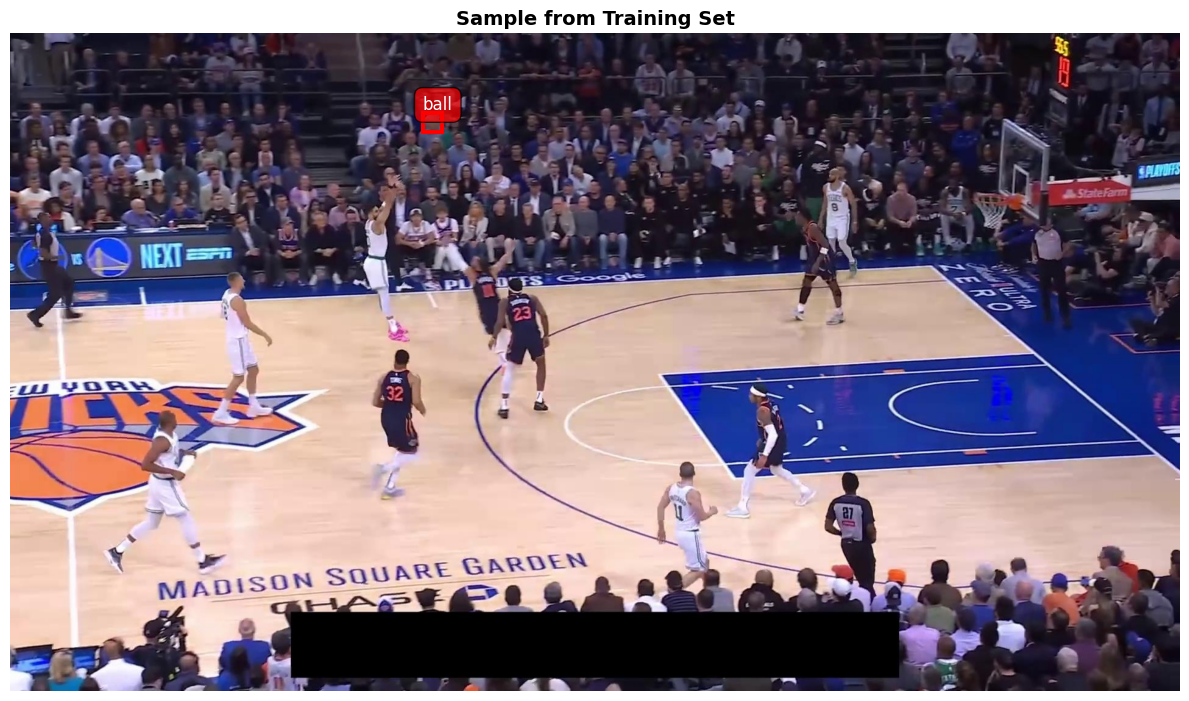

In [11]:
# Visualize a single sample
image, label, boxes = train_dataset[0]
visualize_sample(image, label, boxes, title=f"Sample from Training Set")

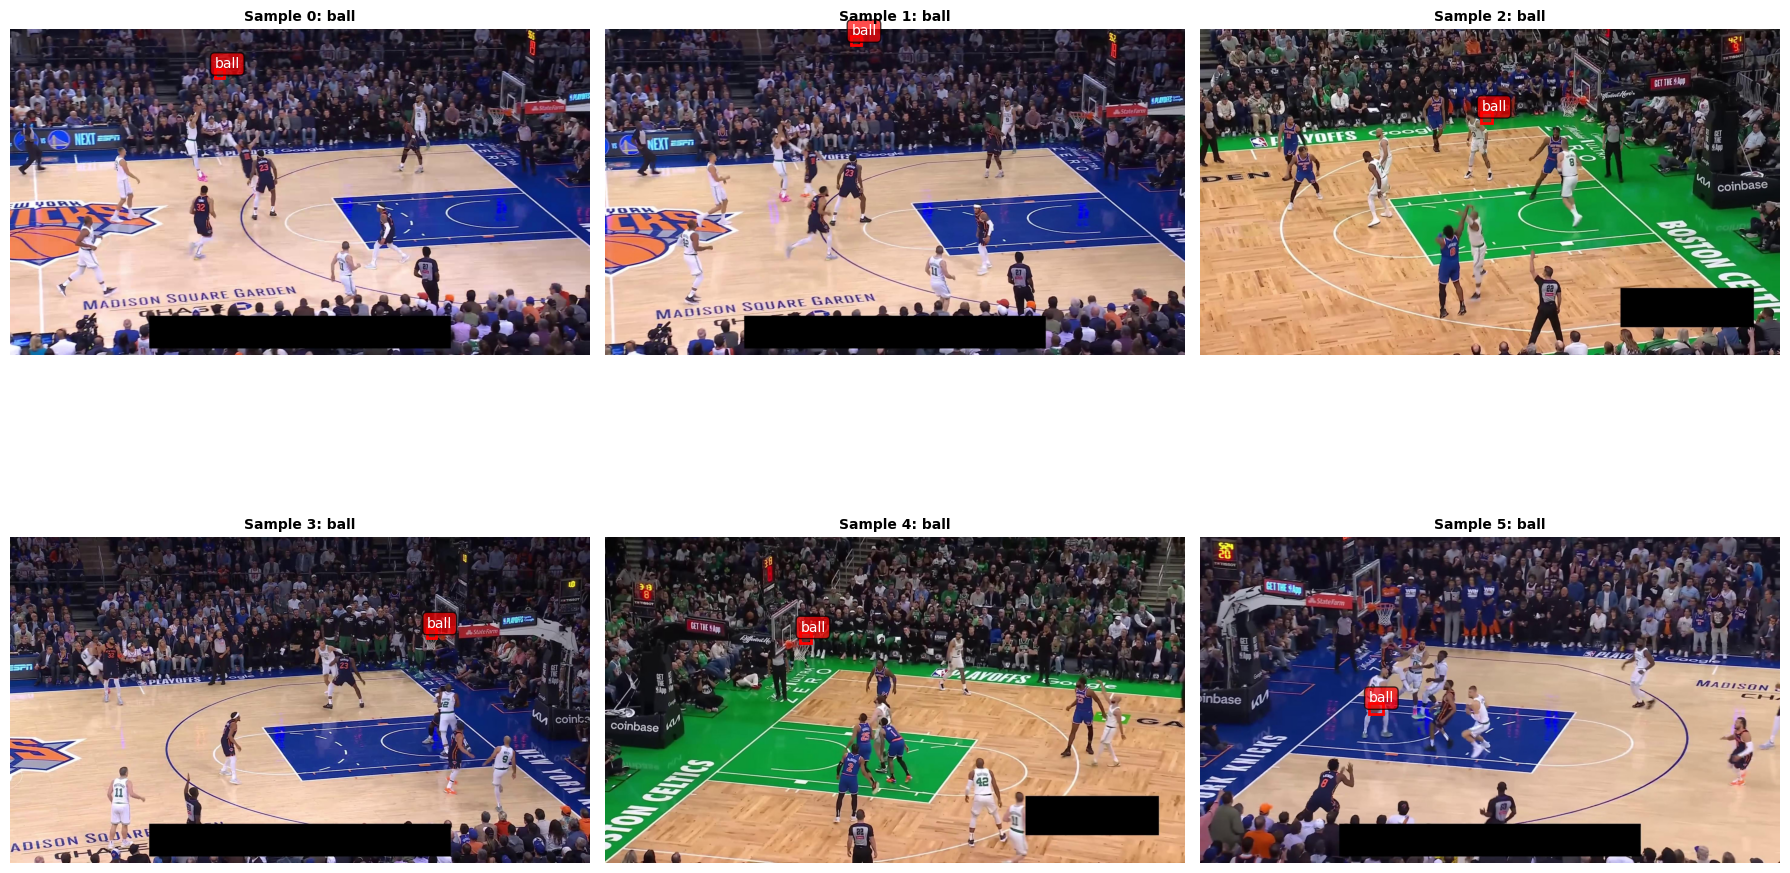

In [12]:
# Visualize a batch of samples
visualize_batch(train_dataset, num_samples=6, cols=3)